In [1]:
from scipy.stats import qmc
import pandas as pd
import pandas as pd
from datetime import datetime, timedelta
import shutil
import os
from sklearn.metrics import mean_squared_error
from math import sqrt
import subprocess
import warnings
import scienceplots
import matplotlib.pyplot as plt
from statsmodels.nonparametric.smoothers_lowess import lowess

import geopandas as gpd
from matplotlib.colors import ListedColormap
import contextily as ctx
import matplotlib.colors as mcolors
warnings.filterwarnings("ignore")

In [2]:
def get_shade(run_folder):
    base_source_folder = run_folder
    control_file = pd.read_csv(os.path.join(base_source_folder, 'HeatSource_Control.csv'))

    cc_start = control_file.loc[7]['VALUE']
    cc_start = pd.to_datetime(cc_start)
    cc_end = control_file.loc[8]['VALUE']
    cc_end = pd.to_datetime(cc_end)

    shade_df = pd.read_csv(os.path.join(base_source_folder, 'outputs', 'Shade.csv'), skiprows=6, usecols=range(1, 185))
    hourly_index = pd.date_range(start=cc_start, end=cc_end + pd.DateOffset(1), freq='D', inclusive='left')  # Closed left ensures end date is exclusive




    shade_df.columns = [float(col) for col in shade_df.columns]
    shade_df.index = hourly_index
    shade = shade_df.mean()
    shade = pd.DataFrame(shade)
    shade.rename(columns={0 : 'Eff Shade'}, inplace=True)

    
    return shade

In [19]:
observed = get_shade(r'D:\Ben_wd\THESIS\heatsource\post_defense\scenarios\scenario_inputs\baseline_vegetation\July_baseline')*100
all_grass = get_shade(r'D:\Ben_wd\THESIS\heatsource\post_defense\scenarios\scenario_inputs\vegetation_buffers\July_grassbuffer')*100
all_trees = get_shade(r'D:\Ben_wd\THESIS\heatsource\post_defense\scenarios\scenario_inputs\vegetation_buffers\July_forestbuffer')*100
#test_grass = get_shade(r'D:\Ben_wd\THESIS\heatsource\WestFork\ModelRuns\Hayes\scenarios\thesis_scenarios\results\ModelBaselines\test')

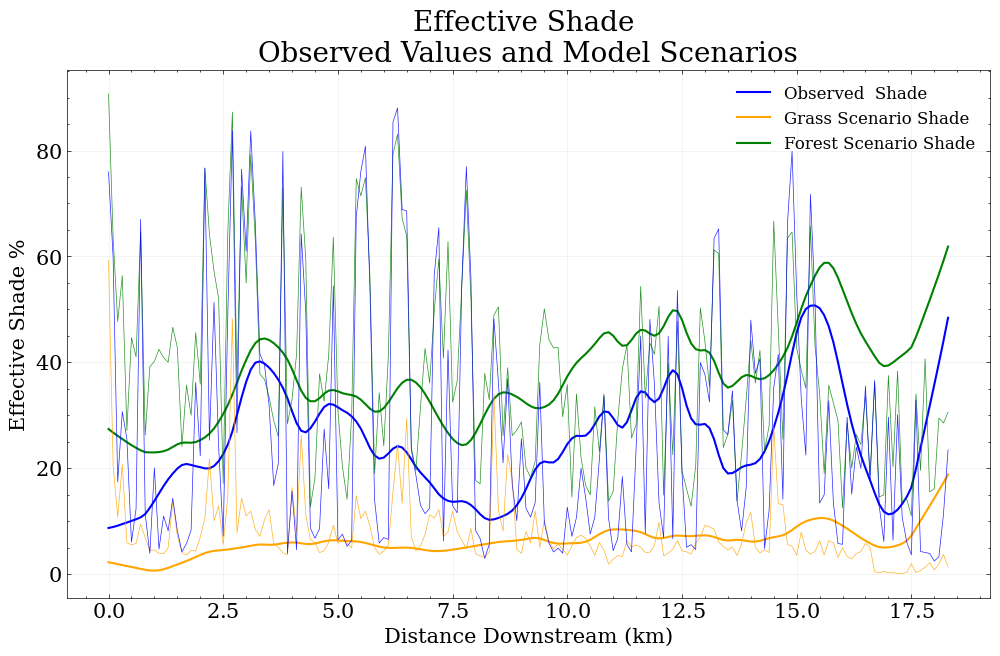

In [21]:

# Applying LOESS smoothing
smoothed_observed = lowess(observed['Eff Shade'], observed.index, frac=0.1)
smoothed_grass = lowess(all_grass['Eff Shade'], all_grass.index, frac=0.1)
smoothed_forested = lowess(all_trees['Eff Shade'], all_trees.index, frac=0.1)


# Creating a DataFrame for smoothed data
smoothed_observed = pd.DataFrame(smoothed_observed[:, 1], index=observed.index, columns=['Smoothed'])
smoothed_grass = pd.DataFrame(smoothed_grass[:, 1], index=all_grass.index, columns=['Smoothed'])
smoothed_forested = pd.DataFrame(smoothed_forested[:, 1], index=all_trees.index, columns=['Smoothed'])


with plt.style.context(['science', 'no-latex']):
    # Plotting original and smoothed data
    plt.figure(figsize=(10, 6))
    #plt.plot(18.3 - shade.index, shade[0], label='Original Data', color='b')
    plt.plot(18.5-smoothed_observed.index, smoothed_observed['Smoothed'], label='Observed  Shade', lw = 1.5, color='blue')
    plt.plot(18.5-smoothed_grass.index, smoothed_grass['Smoothed'], label='Grass Scenario Shade', lw = 1.5, color='orange')
    plt.plot(18.5-smoothed_forested.index, smoothed_forested['Smoothed'], label='Forest Scenario Shade', lw= 1.5, color='green')
    plt.plot(18.5-all_trees.index, all_trees['Eff Shade'], color='green', alpha=.85, lw = .5)#, alpha=.5)
    plt.plot(18.5-all_grass.index, all_grass['Eff Shade'], color='orange', alpha=.85, lw = .5)#, alpha=.5
    #plt.plot(27.2 - test_grass.index, test_grass['Eff Shade'], color='black', alpha=.85, lw = .5)#, alpha=.5)

    plt.plot(18.5-observed.index, observed['Eff Shade'], color='blue',lw = .5, alpha=.85)


    
    plt.ylabel('Effective Shade % (c)', size = 15)
    plt.xlabel('Distance Downstream', size = 15)
    #plt.figure(facecolor='black')

        # Adjust layout
    plt.tight_layout()
    plt.grid(alpha = .2)
    plt.yticks(size= 15)
    plt.xticks(size= 15)
    plt.xlabel('Distance Downstream (km)')
    plt.ylabel('Effective Shade %')
    #plt.vlines(trib_dict_downstream, ymin = 20, ymax = 25, label = 'Tribs',color = 'Orange', linestyles = 'dashed')
    plt.legend(loc = 'upper right', fontsize = 12)
    plt.title('Effective Shade \nObserved Values and Model Scenarios', size = 20)

plt.savefig(os.path.join('D:\Ben_wd\THESIS\heatsource\post_defense', 'Figures', 'Effectiveshadecomparison_updated.png'), bbox_inches='tight', dpi=300)

#plt.savefig(r'D:\Ben_wd\THESIS\figs\Thesis\Effective Shade Comparison.png', bbox_inches='tight', dpi=300)
plt.show()


In [9]:
nodes = gpd.read_file(r'D:\Ben_wd\THESIS\heatsource\post_defense\ttools\ttools_outputs\nodes.shp')
nodes

,Id,NODE_ID,STREAM_ID,STREAM_KM,LENGTH,LONGITUDE,LATITUDE,STREAM_AZM,CHANWIDTH,LEFT,...,ELE_T7_S2,ELE_T7_S3,ELE_T7_S4,ELE_T7_S5,ELE_T8_S1,ELE_T8_S2,ELE_T8_S3,ELE_T8_S4,ELE_T8_S5,geometry
0,0,185.0,0,18.5,17.423244,-90.785066,43.661704,161.507493,4.622692,2.328699,...,298.99893,296.68110,296.68110,294.57623,297.24133,298.99893,298.99893,298.99893,300.61010,POINT (536681.238 184897.962)
1,0,184.0,0,18.4,100.000000,-90.784666,43.660861,172.197642,8.533761,3.941995,...,290.06900,290.06900,289.87024,289.87024,291.79150,291.79150,295.17550,295.17550,297.85470,POINT (536712.646 184804.051)
2,0,183.0,0,18.3,100.000000,-90.784718,43.659978,180.499699,5.389599,2.832738,...,290.20016,291.21720,291.04938,292.01843,290.20016,290.20016,290.06924,290.06924,290.06924,POINT (536707.553 184705.915)
3,0,182.0,0,18.2,100.000000,-90.784664,43.659087,163.258761,8.310317,4.813348,...,291.58762,291.58762,292.34695,292.41970,290.71225,290.48502,290.22537,290.22537,289.93134,POINT (536710.927 184606.983)
4,0,181.0,0,18.1,100.000000,-90.784027,43.658364,160.553509,7.871884,1.602200,...,288.17220,288.44537,288.44537,288.74564,288.17220,288.15982,288.15982,288.15982,288.15982,POINT (536761.617 184526.179)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
181,0,4.0,0,0.4,100.000000,-90.749545,43.553951,52.592814,8.194620,3.500480,...,241.50508,241.53548,241.53548,241.53548,241.48996,241.48996,241.48996,241.50755,241.50755,POINT (539438.557 172900.979)
182,0,3.0,0,0.3,100.000000,-90.748945,43.554674,75.801984,8.272932,3.098544,...,241.86847,241.97499,241.97499,241.91913,241.84962,241.97714,241.97714,242.10411,242.10411,POINT (539487.703 172980.817)
183,0,2.0,0,0.2,100.000000,-90.747919,43.554262,134.325264,11.853601,6.192543,...,240.90565,240.87410,240.97012,240.97012,241.03540,241.03540,241.13968,241.13968,241.26714,POINT (539570.212 172934.288)
184,0,1.0,0,0.1,100.000000,-90.747317,43.553537,179.491807,7.158004,2.925803,...,240.47757,240.47757,240.43636,240.43636,240.84087,240.84087,240.95374,240.95374,241.03824,POINT (539618.146 172853.411)


In [13]:
join = nodes.merge(observed, left_on = 'STREAM_KM', right_index = True)
join.to_file(r'D:\Ben_wd\THESIS\heatsource\post_defense\shp\observed_shade.shp')